In [3]:
!git clone https://github.com/Jsrsky/machine_unlearning_experiments
%cd machine_unlearning_experiments/experiments/animal_faces/sisa

Cloning into 'machine_unlearning_experiments'...
remote: Enumerating objects: 465, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 465 (delta 14), reused 34 (delta 9), pack-reused 374 (from 3)
Receiving objects: 100% (465/465), 628.99 MiB | 41.19 MiB/s, done.
Resolving deltas: 100% (149/149), done.
Updating files: 100% (69/69), done.
/kaggle/working/machine_unlearning_experiments/experiments/animal_faces/sisa


## Dependencies

In [4]:
import sys
import json
from pathlib import Path
from torchvision import datasets

## Utils

In [5]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
data_root = project_root / 'data'
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook
setup_notebook()

Notebook setup completed. Project root added to sys.path: /kaggle/working/machine_unlearning_experiments


In [6]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed
set_seed()

# Init model
from models.effnetb0 import init_model_effnetb0

# Create sisa structure
from methods.sisa.sisa_utils import create_sisa_structure

# Recreate sisa dataloaders from json file
from methods.sisa.sisa_utils import recreate_sisa_dataloaders

# SISA train & test loop
from methods.sisa.sisa_train_test import sisa_train, sisa_test, retrain_sisa_framework

# Aggregate SISA models, via weighted voting
from methods.sisa.sisa_utils import evaluate_aggregated_model, update_sisa_structure

Device used: cuda


## Parameters (arbitrary chosen)

In [7]:
BATCH_SIZE = 64

LEARNING_RATE = 0.001

EPOCHS = 3

SHARDS = 3

SLICES = 5

stt.MULTI_GPU = True

# SISA structure

## Get data transform

In [8]:
*_, transform = init_model_effnetb0()
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

Init model...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 144MB/s] 


Done initializing model.
Model ID: 136372557791488, Optimizer ID: 136372557792400, Criterion ID: 136372557791296


## Load dataset

In [9]:
data_root = Path('/kaggle/input/animal-faces') # Only add if in kaggle env

In [10]:
train_dataset = datasets.ImageFolder(root=data_root/'afhq/train', transform=transform)
test_dataset = datasets.ImageFolder(root=data_root/'afhq/val', transform=transform)

## Create SISA structure

In [11]:
create_sisa_structure(train_dataset, shards=SHARDS, slices_per_shard=SLICES)

SISA structure saved to sisa_structure.json


In [13]:
sisa_structure_file = 'sisa_structure.json'

## Prepare DataLoaders from json file

In [11]:
dataloaders, classes = recreate_sisa_dataloaders(
    datasets=(train_dataset, test_dataset),
    info_file_path=sisa_structure_file,
    batch_size=BATCH_SIZE,
    val_ratio=0.1
)

# Train using SISA framework

## Models output path

In [12]:
save_models_metrics_dir = './sisa_models'

## Call train

In [13]:
import time
start_time = time.perf_counter()

sisa_train(
    dataloaders=dataloaders, 
    num_epochs=EPOCHS, 
    save_models_metrics_dir=save_models_metrics_dir, 
    init_model_func=init_model_effnetb0,
    learning_rate=LEARNING_RATE,
    )

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Training shard: shard_0
Init model...
Done initializing model.
Model ID: 135288898874544, Optimizer ID: 135288898868064, Criterion ID: 135288898877472
  Training slice: slice_0


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch [1/3], Train Loss: 0.2502, Train Accuracy: 0.9237, Val Loss: 0.0574, Val Accuracy: 0.9691
Epoch 1: New best validation accuracy: 0.9691. Model saved to ./sisa_models/shard_0_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


Epoch [2/3], Train Loss: 0.0458, Train Accuracy: 0.9875, Val Loss: 0.0031, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_0_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Epoch [3/3], Train Loss: 0.0501, Train Accuracy: 0.9852, Val Loss: 0.0576, Val Accuracy: 0.9794
Training complete for ./sisa_models/shard_0_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_0_slice_0_EffNetB0_AFHQ_history.json'.
  Training slice: slice_1


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch [1/3], Train Loss: 0.0478, Train Accuracy: 0.9863, Val Loss: 0.0337, Val Accuracy: 0.9897
Epoch 1: New best validation accuracy: 0.9897. Model saved to ./sisa_models/shard_0_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch [2/3], Train Loss: 0.0245, Train Accuracy: 0.9897, Val Loss: 0.0193, Val Accuracy: 0.9897


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch [3/3], Train Loss: 0.0042, Train Accuracy: 1.0000, Val Loss: 0.0498, Val Accuracy: 0.9794
Training complete for ./sisa_models/shard_0_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_0_slice_1_EffNetB0_AFHQ_history.json'.
  Training slice: slice_2


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch [1/3], Train Loss: 0.0508, Train Accuracy: 0.9875, Val Loss: 0.1089, Val Accuracy: 0.9691
Epoch 1: New best validation accuracy: 0.9691. Model saved to ./sisa_models/shard_0_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


Epoch [2/3], Train Loss: 0.0360, Train Accuracy: 0.9954, Val Loss: 0.0013, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_0_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


Epoch [3/3], Train Loss: 0.0146, Train Accuracy: 0.9943, Val Loss: 0.0017, Val Accuracy: 1.0000
Training complete for ./sisa_models/shard_0_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_0_slice_2_EffNetB0_AFHQ_history.json'.
  Training slice: slice_3


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


Epoch [1/3], Train Loss: 0.0707, Train Accuracy: 0.9852, Val Loss: 0.0221, Val Accuracy: 0.9897
Epoch 1: New best validation accuracy: 0.9897. Model saved to ./sisa_models/shard_0_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch [2/3], Train Loss: 0.0171, Train Accuracy: 0.9977, Val Loss: 0.0249, Val Accuracy: 0.9897


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


Epoch [3/3], Train Loss: 0.0057, Train Accuracy: 0.9989, Val Loss: 0.0016, Val Accuracy: 1.0000
Epoch 3: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_0_slice_3_EffNetB0_AFHQ_model.pth.
Training complete for ./sisa_models/shard_0_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_0_slice_3_EffNetB0_AFHQ_history.json'.
  Training slice: slice_4


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch [1/3], Train Loss: 0.0431, Train Accuracy: 0.9920, Val Loss: 0.1112, Val Accuracy: 0.9691
Epoch 1: New best validation accuracy: 0.9691. Model saved to ./sisa_models/shard_0_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch [2/3], Train Loss: 0.0204, Train Accuracy: 0.9932, Val Loss: 0.0467, Val Accuracy: 0.9794
Epoch 2: New best validation accuracy: 0.9794. Model saved to ./sisa_models/shard_0_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch [3/3], Train Loss: 0.0048, Train Accuracy: 0.9989, Val Loss: 0.0698, Val Accuracy: 0.9794
Training complete for ./sisa_models/shard_0_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_0_slice_4_EffNetB0_AFHQ_history.json'.
Saved final shard model to ./sisa_models/shard_0_final_model.pth
Training shard: shard_1
Init model...
Done initializing model.
Model ID: 135288875484976, Optimizer ID: 135288898874592, Criterion ID: 135289588862112
  Training slice: slice_0


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


Epoch [1/3], Train Loss: 0.2943, Train Accuracy: 0.8998, Val Loss: 0.0036, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_1_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch [2/3], Train Loss: 0.0259, Train Accuracy: 0.9909, Val Loss: 0.0688, Val Accuracy: 0.9691


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch [3/3], Train Loss: 0.0265, Train Accuracy: 0.9920, Val Loss: 0.0079, Val Accuracy: 1.0000
Training complete for ./sisa_models/shard_1_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_1_slice_0_EffNetB0_AFHQ_history.json'.
  Training slice: slice_1


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Epoch [1/3], Train Loss: 0.0504, Train Accuracy: 0.9829, Val Loss: 0.0081, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_1_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch [2/3], Train Loss: 0.0422, Train Accuracy: 0.9886, Val Loss: 0.0523, Val Accuracy: 0.9794


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


Epoch [3/3], Train Loss: 0.0230, Train Accuracy: 0.9954, Val Loss: 0.0223, Val Accuracy: 0.9897
Training complete for ./sisa_models/shard_1_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_1_slice_1_EffNetB0_AFHQ_history.json'.
  Training slice: slice_2


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]


Epoch [1/3], Train Loss: 0.0291, Train Accuracy: 0.9909, Val Loss: 0.0149, Val Accuracy: 0.9897
Epoch 1: New best validation accuracy: 0.9897. Model saved to ./sisa_models/shard_1_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


Epoch [2/3], Train Loss: 0.0176, Train Accuracy: 0.9966, Val Loss: 0.0110, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_1_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch [3/3], Train Loss: 0.0055, Train Accuracy: 0.9989, Val Loss: 0.0129, Val Accuracy: 1.0000
Training complete for ./sisa_models/shard_1_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_1_slice_2_EffNetB0_AFHQ_history.json'.
  Training slice: slice_3


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]


Epoch [1/3], Train Loss: 0.0411, Train Accuracy: 0.9886, Val Loss: 0.0023, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_1_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


Epoch [2/3], Train Loss: 0.0179, Train Accuracy: 0.9954, Val Loss: 0.0004, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch [3/3], Train Loss: 0.0071, Train Accuracy: 0.9977, Val Loss: 0.0006, Val Accuracy: 1.0000
Training complete for ./sisa_models/shard_1_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_1_slice_3_EffNetB0_AFHQ_history.json'.
  Training slice: slice_4


Evaluating on validation set...: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Epoch [1/3], Train Loss: 0.0216, Train Accuracy: 0.9920, Val Loss: 0.0115, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_1_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch [2/3], Train Loss: 0.0257, Train Accuracy: 0.9898, Val Loss: 0.0427, Val Accuracy: 0.9897


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch [3/3], Train Loss: 0.0192, Train Accuracy: 0.9943, Val Loss: 0.0296, Val Accuracy: 0.9897
Training complete for ./sisa_models/shard_1_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_1_slice_4_EffNetB0_AFHQ_history.json'.
Saved final shard model to ./sisa_models/shard_1_final_model.pth
Training shard: shard_2
Init model...
Done initializing model.
Model ID: 135288898677600, Optimizer ID: 135288898680960, Criterion ID: 135288898677504
  Training slice: slice_0


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch [1/3], Train Loss: 0.2671, Train Accuracy: 0.9055, Val Loss: 0.3720, Val Accuracy: 0.9588
Epoch 1: New best validation accuracy: 0.9588. Model saved to ./sisa_models/shard_2_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


Epoch [2/3], Train Loss: 0.0997, Train Accuracy: 0.9658, Val Loss: 0.1024, Val Accuracy: 0.9381


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


Epoch [3/3], Train Loss: 0.0235, Train Accuracy: 0.9977, Val Loss: 0.0781, Val Accuracy: 0.9691
Epoch 3: New best validation accuracy: 0.9691. Model saved to ./sisa_models/shard_2_slice_0_EffNetB0_AFHQ_model.pth.
Training complete for ./sisa_models/shard_2_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_2_slice_0_EffNetB0_AFHQ_history.json'.
  Training slice: slice_1


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch [1/3], Train Loss: 0.0628, Train Accuracy: 0.9841, Val Loss: 0.0021, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_2_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


Epoch [2/3], Train Loss: 0.0344, Train Accuracy: 0.9886, Val Loss: 0.0088, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Epoch [3/3], Train Loss: 0.0184, Train Accuracy: 0.9943, Val Loss: 0.0127, Val Accuracy: 1.0000
Training complete for ./sisa_models/shard_2_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_2_slice_1_EffNetB0_AFHQ_history.json'.
  Training slice: slice_2


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


Epoch [1/3], Train Loss: 0.0378, Train Accuracy: 0.9886, Val Loss: 0.0087, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_2_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Epoch [2/3], Train Loss: 0.0164, Train Accuracy: 0.9966, Val Loss: 0.0383, Val Accuracy: 0.9897


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


Epoch [3/3], Train Loss: 0.0095, Train Accuracy: 0.9977, Val Loss: 0.0209, Val Accuracy: 0.9897
Training complete for ./sisa_models/shard_2_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_2_slice_2_EffNetB0_AFHQ_history.json'.
  Training slice: slice_3


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


Epoch [1/3], Train Loss: 0.0418, Train Accuracy: 0.9886, Val Loss: 0.0019, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_2_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Epoch [2/3], Train Loss: 0.0123, Train Accuracy: 0.9966, Val Loss: 0.0075, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch [3/3], Train Loss: 0.0089, Train Accuracy: 0.9989, Val Loss: 0.0139, Val Accuracy: 0.9897
Training complete for ./sisa_models/shard_2_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_2_slice_3_EffNetB0_AFHQ_history.json'.
  Training slice: slice_4


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


Epoch [1/3], Train Loss: 0.0194, Train Accuracy: 0.9886, Val Loss: 0.0140, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_models/shard_2_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


Epoch [2/3], Train Loss: 0.0323, Train Accuracy: 0.9921, Val Loss: 0.0078, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]

Epoch [3/3], Train Loss: 0.0142, Train Accuracy: 0.9943, Val Loss: 0.0629, Val Accuracy: 0.9897
Training complete for ./sisa_models/shard_2_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_models/shard_2_slice_4_EffNetB0_AFHQ_history.json'.
Saved final shard model to ./sisa_models/shard_2_final_model.pth
Execution time: 445.223516 seconds


## Call test

In [14]:
sisa_test(
    dataloaders=dataloaders, 
    saved_models_metrics_dir=save_models_metrics_dir, 
    init_model_func=init_model_effnetb0,
    clear_solo_models_preds=True)

Init model...
Done initializing model.
Model ID: 135288898864896, Optimizer ID: 135288898866192, Criterion ID: 135288898865760
Loading and testing model: ./sisa_models/shard_0_EffNetB0_AFHQ


Evaluating model: ./sisa_models/shard_0_final_model.pth: 100%|██████████| 24/24 [00:18<00:00,  1.29it/s]


Predictions and labels saved to ./sisa_models/shard_0_EffNetB0_AFHQ_predictions.json
Init model...
Done initializing model.
Model ID: 135288875339200, Optimizer ID: 135288875336176, Criterion ID: 135288875341648
Loading and testing model: ./sisa_models/shard_1_EffNetB0_AFHQ


Evaluating model: ./sisa_models/shard_1_final_model.pth: 100%|██████████| 24/24 [00:11<00:00,  2.05it/s]


Predictions and labels saved to ./sisa_models/shard_1_EffNetB0_AFHQ_predictions.json
Init model...
Done initializing model.
Model ID: 135288875497984, Optimizer ID: 135288875489392, Criterion ID: 135288875495344
Loading and testing model: ./sisa_models/shard_2_EffNetB0_AFHQ


Evaluating model: ./sisa_models/shard_2_final_model.pth: 100%|██████████| 24/24 [00:11<00:00,  2.11it/s]

Predictions and labels saved to ./sisa_models/shard_2_EffNetB0_AFHQ_predictions.json
Evaluation results saved to sisa_final_evaluation.json


## Shard models assembly (weighted voting, w=accuracy)

In [17]:
with open("sisa_final_evaluation.json", "r") as f:
    results = json.load(f)

Shard shard_0 Metrics:
  Accuracy: 0.9987
  Precision: 0.9987
  Recall: 0.9987
  F1 Score: 0.9987
Shard shard_1 Metrics:
  Accuracy: 0.9847
  Precision: 0.9849
  Recall: 0.9847
  F1 Score: 0.9847
Shard shard_2 Metrics:
  Accuracy: 0.9867
  Precision: 0.9869
  Recall: 0.9867
  F1 Score: 0.9867

Aggregated Model Metrics:
  Accuracy: 0.9973
  Precision: 0.9973
  Recall: 0.9973
  F1 Score: 0.9973


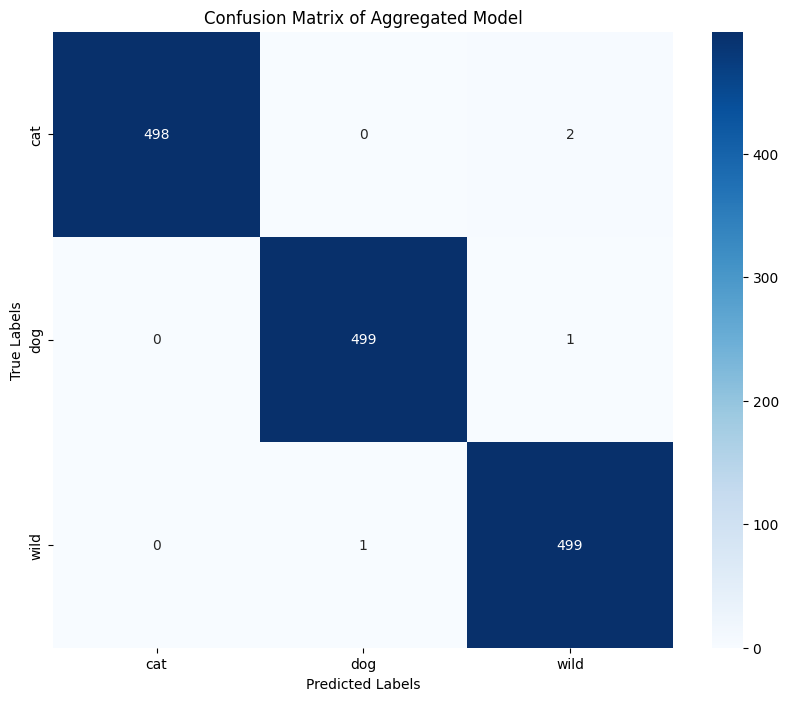

In [18]:
evaluate_aggregated_model(results, classes)

# SISA re-train

## Paths to data info

In [14]:
samples_to_delete = project_root/'experiments/animal_faces/naive/afhq_samples_to_unlearn_30per.json'
sisa_structure = 'sisa_structure.json'
updated_sisa_structure = 'updated_sisa_strucute.json'
deleted_samples = 'deleted_samples.json'

## Update sisa structure -> delete samples 

In [15]:
affected_shards = update_sisa_structure(samples_to_delete, sisa_structure, updated_sisa_structure,deleted_samples)

Retraining Plan:
  Shard: shard_0, Start from Slice: slice_0 onward
  Shard: shard_1, Start from Slice: slice_0 onward
  Shard: shard_2, Start from Slice: slice_0 onward


## Recreate DataLoaders from json file

In [18]:
dataloaders, classes = recreate_sisa_dataloaders(
    datasets=(train_dataset, test_dataset),
    info_file_path=updated_sisa_structure,
    batch_size=BATCH_SIZE,
    val_ratio=0.1
)

## Models output path

In [19]:
save_path = "./sisa_updated_models"

## Retrain the affected shards

In [20]:
import time
start_time = time.perf_counter()

retrain_sisa_framework(
    dataloaders=dataloaders,
    affected_shards=affected_shards,
    num_epochs=EPOCHS,
    save_models_metrics_dir=save_path,
    init_model_func=init_model_effnetb0, 
    learning_rate=LEARNING_RATE
)

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

Retraining shard: shard_0
Init model...
Done initializing model.
Model ID: 136373262554336, Optimizer ID: 136372544896688, Criterion ID: 136372544896784
  Retraining slice: slice_0


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


Epoch [1/3], Train Loss: 0.3697, Train Accuracy: 0.8723, Val Loss: 0.0019, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_0_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


Epoch [2/3], Train Loss: 0.0516, Train Accuracy: 0.9836, Val Loss: 0.1110, Val Accuracy: 0.9701


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


Epoch [3/3], Train Loss: 0.0663, Train Accuracy: 0.9804, Val Loss: 0.1019, Val Accuracy: 0.9701
Training complete for ./sisa_updated_models/shard_0_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_0_slice_0_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_1


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]


Epoch [1/3], Train Loss: 0.0575, Train Accuracy: 0.9791, Val Loss: 0.0181, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_0_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


Epoch [2/3], Train Loss: 0.0331, Train Accuracy: 0.9872, Val Loss: 0.0136, Val Accuracy: 0.9855


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch [3/3], Train Loss: 0.0138, Train Accuracy: 0.9952, Val Loss: 0.0327, Val Accuracy: 0.9855
Training complete for ./sisa_updated_models/shard_0_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_0_slice_1_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_2


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch [1/3], Train Loss: 0.0321, Train Accuracy: 0.9871, Val Loss: 0.0750, Val Accuracy: 0.9706
Epoch 1: New best validation accuracy: 0.9706. Model saved to ./sisa_updated_models/shard_0_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


Epoch [2/3], Train Loss: 0.0460, Train Accuracy: 0.9839, Val Loss: 0.0003, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_0_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]


Epoch [3/3], Train Loss: 0.0415, Train Accuracy: 0.9919, Val Loss: 0.0098, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_0_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_0_slice_2_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_3


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


Epoch [1/3], Train Loss: 0.0559, Train Accuracy: 0.9810, Val Loss: 0.0151, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_0_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]


Epoch [2/3], Train Loss: 0.0247, Train Accuracy: 0.9921, Val Loss: 0.0202, Val Accuracy: 0.9857


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]


Epoch [3/3], Train Loss: 0.0049, Train Accuracy: 1.0000, Val Loss: 0.0056, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_0_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_0_slice_3_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_4


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


Epoch [1/3], Train Loss: 0.0901, Train Accuracy: 0.9806, Val Loss: 0.1464, Val Accuracy: 0.9265
Epoch 1: New best validation accuracy: 0.9265. Model saved to ./sisa_updated_models/shard_0_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]


Epoch [2/3], Train Loss: 0.0291, Train Accuracy: 0.9903, Val Loss: 0.0290, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_0_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]


Epoch [3/3], Train Loss: 0.0097, Train Accuracy: 0.9951, Val Loss: 0.0533, Val Accuracy: 0.9853
Training complete for ./sisa_updated_models/shard_0_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_0_slice_4_EffNetB0_AFHQ_history.json'.
Saved updated model for shard_0 to ./sisa_updated_models/shard_0_final_model.pth
Retraining shard: shard_1
Init model...
Done initializing model.
Model ID: 136372565042528, Optimizer ID: 136375975867488, Criterion ID: 136375974611072
  Retraining slice: slice_0


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch [1/3], Train Loss: 0.3519, Train Accuracy: 0.8964, Val Loss: 0.0060, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_1_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]


Epoch [2/3], Train Loss: 0.0211, Train Accuracy: 0.9934, Val Loss: 0.0839, Val Accuracy: 0.9851


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


Epoch [3/3], Train Loss: 0.0710, Train Accuracy: 0.9868, Val Loss: 0.4629, Val Accuracy: 0.9104
Training complete for ./sisa_updated_models/shard_1_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_1_slice_0_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_1


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


Epoch [1/3], Train Loss: 0.1532, Train Accuracy: 0.9517, Val Loss: 0.0101, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_1_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]


Epoch [2/3], Train Loss: 0.0863, Train Accuracy: 0.9662, Val Loss: 0.0080, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]


Epoch [3/3], Train Loss: 0.0197, Train Accuracy: 0.9968, Val Loss: 0.0022, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_1_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_1_slice_1_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_2


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


Epoch [1/3], Train Loss: 0.0330, Train Accuracy: 0.9917, Val Loss: 0.0026, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_1_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]


Epoch [2/3], Train Loss: 0.0084, Train Accuracy: 0.9983, Val Loss: 0.0019, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]


Epoch [3/3], Train Loss: 0.0117, Train Accuracy: 0.9934, Val Loss: 0.0031, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_1_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_1_slice_2_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_3


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


Epoch [1/3], Train Loss: 0.0556, Train Accuracy: 0.9838, Val Loss: 0.0672, Val Accuracy: 0.9706
Epoch 1: New best validation accuracy: 0.9706. Model saved to ./sisa_updated_models/shard_1_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]


Epoch [2/3], Train Loss: 0.0457, Train Accuracy: 0.9870, Val Loss: 0.0272, Val Accuracy: 0.9853
Epoch 2: New best validation accuracy: 0.9853. Model saved to ./sisa_updated_models/shard_1_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


Epoch [3/3], Train Loss: 0.0111, Train Accuracy: 0.9984, Val Loss: 0.0189, Val Accuracy: 1.0000
Epoch 3: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_1_slice_3_EffNetB0_AFHQ_model.pth.
Training complete for ./sisa_updated_models/shard_1_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_1_slice_3_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_4


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


Epoch [1/3], Train Loss: 0.0436, Train Accuracy: 0.9887, Val Loss: 0.0487, Val Accuracy: 0.9855
Epoch 1: New best validation accuracy: 0.9855. Model saved to ./sisa_updated_models/shard_1_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


Epoch [2/3], Train Loss: 0.0154, Train Accuracy: 0.9968, Val Loss: 0.0120, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_1_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


Epoch [3/3], Train Loss: 0.0248, Train Accuracy: 0.9952, Val Loss: 0.0026, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_1_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_1_slice_4_EffNetB0_AFHQ_history.json'.
Saved updated model for shard_1 to ./sisa_updated_models/shard_1_final_model.pth
Retraining shard: shard_2
Init model...
Done initializing model.
Model ID: 136372534181648, Optimizer ID: 136373262341920, Criterion ID: 136373262349120
  Retraining slice: slice_0


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


Epoch [1/3], Train Loss: 0.3495, Train Accuracy: 0.8813, Val Loss: 0.0581, Val Accuracy: 0.9853
Epoch 1: New best validation accuracy: 0.9853. Model saved to ./sisa_updated_models/shard_2_slice_0_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


Epoch [2/3], Train Loss: 0.0410, Train Accuracy: 0.9870, Val Loss: 0.0241, Val Accuracy: 0.9853


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]


Epoch [3/3], Train Loss: 0.0359, Train Accuracy: 0.9886, Val Loss: 0.0803, Val Accuracy: 0.9853
Training complete for ./sisa_updated_models/shard_2_slice_0_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_2_slice_0_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_1


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


Epoch [1/3], Train Loss: 0.1088, Train Accuracy: 0.9627, Val Loss: 0.0668, Val Accuracy: 0.9853
Epoch 1: New best validation accuracy: 0.9853. Model saved to ./sisa_updated_models/shard_2_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]


Epoch [2/3], Train Loss: 0.0535, Train Accuracy: 0.9838, Val Loss: 0.0020, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_2_slice_1_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


Epoch [3/3], Train Loss: 0.0347, Train Accuracy: 0.9919, Val Loss: 0.0126, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_2_slice_1_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_2_slice_1_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_2


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


Epoch [1/3], Train Loss: 0.0378, Train Accuracy: 0.9848, Val Loss: 0.0437, Val Accuracy: 0.9848
Epoch 1: New best validation accuracy: 0.9848. Model saved to ./sisa_updated_models/shard_2_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]


Epoch [2/3], Train Loss: 0.0326, Train Accuracy: 0.9899, Val Loss: 0.0154, Val Accuracy: 1.0000
Epoch 2: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_2_slice_2_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


Epoch [3/3], Train Loss: 0.0109, Train Accuracy: 0.9983, Val Loss: 0.0067, Val Accuracy: 1.0000
Training complete for ./sisa_updated_models/shard_2_slice_2_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_2_slice_2_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_3


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Epoch [1/3], Train Loss: 0.0334, Train Accuracy: 0.9837, Val Loss: 0.0163, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_2_slice_3_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


Epoch [2/3], Train Loss: 0.0113, Train Accuracy: 0.9984, Val Loss: 0.0089, Val Accuracy: 1.0000


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


Epoch [3/3], Train Loss: 0.0092, Train Accuracy: 0.9951, Val Loss: 0.0242, Val Accuracy: 0.9853
Training complete for ./sisa_updated_models/shard_2_slice_3_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_2_slice_3_EffNetB0_AFHQ_history.json'.
  Retraining slice: slice_4


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]


Epoch [1/3], Train Loss: 0.0610, Train Accuracy: 0.9804, Val Loss: 0.0072, Val Accuracy: 1.0000
Epoch 1: New best validation accuracy: 1.0000. Model saved to ./sisa_updated_models/shard_2_slice_4_EffNetB0_AFHQ_model.pth.


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


Epoch [2/3], Train Loss: 0.0269, Train Accuracy: 0.9918, Val Loss: 0.0350, Val Accuracy: 0.9853


Evaluating on validation set...: 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

Epoch [3/3], Train Loss: 0.0133, Train Accuracy: 0.9918, Val Loss: 0.0222, Val Accuracy: 0.9853
Training complete for ./sisa_updated_models/shard_2_slice_4_EffNetB0_AFHQ. Training stats saved to './sisa_updated_models/shard_2_slice_4_EffNetB0_AFHQ_history.json'.
Saved updated model for shard_2 to ./sisa_updated_models/shard_2_final_model.pth
Execution time: 386.733195 seconds


## Re-test new SISA models

In [21]:
sisa_test(
    dataloaders=dataloaders, 
    saved_models_metrics_dir=save_path, 
    init_model_func=init_model_effnetb0,
    clear_solo_models_preds=True)

Init model...
Done initializing model.
Model ID: 136372534067552, Optimizer ID: 136372534070912, Criterion ID: 136372534067888
Loading and testing model: ./sisa_updated_models/shard_0_EffNetB0_AFHQ


Evaluating model: ./sisa_updated_models/shard_0_final_model.pth: 100%|██████████| 24/24 [00:23<00:00,  1.03it/s]


Predictions and labels saved to ./sisa_updated_models/shard_0_EffNetB0_AFHQ_predictions.json
Init model...
Done initializing model.
Model ID: 136372534221440, Optimizer ID: 136372534222592, Criterion ID: 136372534215248
Loading and testing model: ./sisa_updated_models/shard_1_EffNetB0_AFHQ


Evaluating model: ./sisa_updated_models/shard_1_final_model.pth: 100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


Predictions and labels saved to ./sisa_updated_models/shard_1_EffNetB0_AFHQ_predictions.json
Init model...
Done initializing model.
Model ID: 136372544890640, Optimizer ID: 136372544883440, Criterion ID: 136372544889296
Loading and testing model: ./sisa_updated_models/shard_2_EffNetB0_AFHQ


Evaluating model: ./sisa_updated_models/shard_2_final_model.pth: 100%|██████████| 24/24 [00:14<00:00,  1.70it/s]

Predictions and labels saved to ./sisa_updated_models/shard_2_EffNetB0_AFHQ_predictions.json
Evaluation results saved to sisa_final_evaluation.json


## Shard models assembly (weighted voting, w=accuracy)

In [22]:
with open("sisa_final_evaluation.json", "r") as f:
    results = json.load(f)

Shard shard_0 Metrics:
  Accuracy: 0.9907
  Precision: 0.9909
  Recall: 0.9907
  F1 Score: 0.9907
Shard shard_1 Metrics:
  Accuracy: 0.9913
  Precision: 0.9914
  Recall: 0.9913
  F1 Score: 0.9913
Shard shard_2 Metrics:
  Accuracy: 0.9820
  Precision: 0.9824
  Recall: 0.9820
  F1 Score: 0.9819

Aggregated Model Metrics:
  Accuracy: 0.9940
  Precision: 0.9941
  Recall: 0.9940
  F1 Score: 0.9940


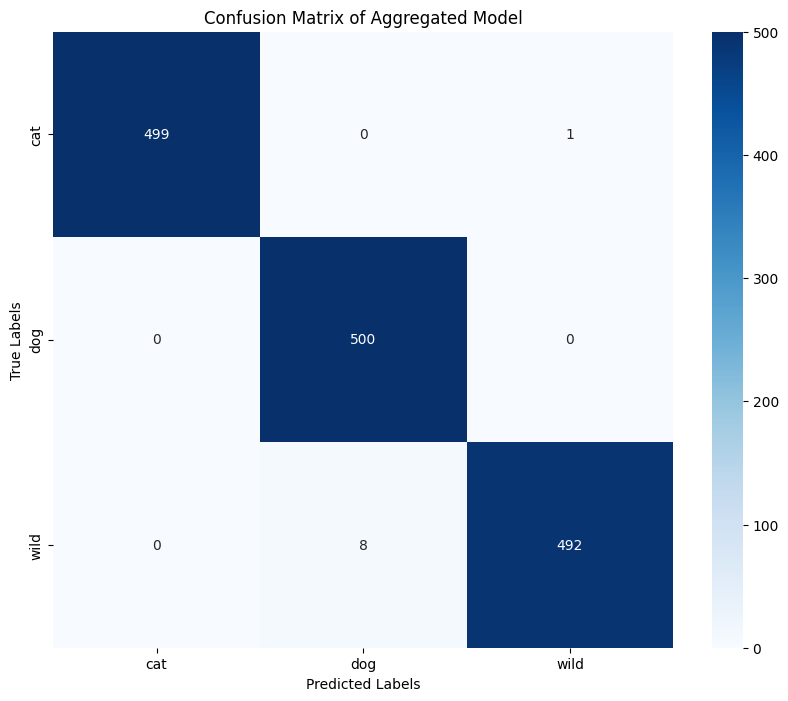

In [23]:
evaluate_aggregated_model(results, classes)